# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #5
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, March 2nd, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Monte Carlo and Simulation Revisited
In Homework #2, we used simulation to compute the expected values of functions of random variables. That is, given a random variable $X$, defined over $\mathbb{R}$, distributed according to the pdf $f_X$, and given a real-valued function of $X$, $h(X)$, we approximated $\mathbb{E}[h(X)]$ as follows
$$
\mathbb{E}[h(X)] = \int_{\mathbb{R}} h(x)f_X(x) dx \approx \frac{1}{N} \sum_{i=1}^N h(X_i), \quad X_i \sim f_X
$$

Now, suppose that, instead of being given the distribution $f_X$ and $h(X)$, you were simply asked to evaluate the following complex integral:
$$
I=\int_{0}^{\infty} \frac{x^4\, \sin\left(\sqrt{\ln{(x+1)}}\right)e^{-x}}{2+(x-4)^2} \, dx 
$$
A clever way to apply our Monte Carlo techniques would be to split the integrand as $h(x)f_X(x)$, and then approximate the integral as we have done in Homework #2:
$$
I = \int_{0}^{\infty} h(x)\,f_X(x) dx  \approx \frac{1}{N} \sum\limits_{i=1}^{N} h(X_i)$$ 
where the $X_i$'s are independently drawn from $f_X(x)$. 

We denote the approximation of the integral as follows
$$\hat{I} = \frac{1}{N} \sum\limits_{i=1}^{N} h(X_i), \quad X_i \sim f_X.$$


### Part A:

Rewrite your integrand as a product of two functions, $h(x)g(x)$, which can then be expressed as $h(x)f_X(x)$, where $f_X$ is a pdf (you may use one of the splits we propose in Part B or create your own). Explain why your choice of $h$ is appropriate. Explain why your choice of $g$ is appropriate for creating a pdf $f_X$.

(**Hint:** think about what you would have to do do turn $g$ into a good pdf and $h$ into a function that can be evaluated at multiple samples from this pdf. Think about how to choose these two functions to make your Monte Carlo approximation of $I$ as accurate as possible.)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

# import for integration calculation
import scipy.integrate as spi

# Rewrite your integrand as a product of two functions

I decided to separate $g(x)$ in a way that would make the overall integration calculation more simple. The selected $g(x)$ is a convenient break off from the full expression for the integrand. 

The final rewrite can be expressed as:

$$
\begin{align}
&h(x) = \frac{x^4\mathrm{sin}(\sqrt{\mathrm{ln}(x+1)})}{2 + (x-4)^2} \\
&g(x) = \mathrm{exp}(-x)
\end{align}
$$

### Part B:

- Use $\frac{1}{2+(x-4)^2}$ to create your pdf $f_X$. Implement a Metropolis algorithm to sample from $f_X$. Run the simulation 50 times for 150,000 points. Report the value of $\hat{I}$ and that of Var[${\hat{I}}$].


- Use $xe^{-x}$ to create your pdf $f_X$. Implement a Metropolis algorithm to sample from $f_X$. Run the simulation 50 times for 150,000 points. Report the value of $\hat{I}$ and that of Var[${\hat{I}}$].


- Compare the variance of your two estimates. Which choice of $f_X$ is better? Explain why.

# Define the required functions and normalize the first p.d.f

We need to divice by a normalizing constant for $\frac{1}{2+(x-4)^2}$ since it does not integrate to 1.

In [2]:
# define the first pdf and its h(x)
def first_pdf(x):
    return 1.0/(2+np.square(x-4))

# take the pdf and divide by a normalizing constant
normalizer_frac = spi.quad(lambda x: first_pdf(x), 0, 100000)[0]
first_pdf_target = lambda x: first_pdf(x)/normalizer_frac

def first_pdf_h(x):
    return (x**4)*np.sin(np.sqrt(np.log(x+1)))*(np.exp(-x))*normalizer_frac

# define the second pdf and its h(x)
def second_pdf_target(x):
    return x*np.exp(-x)

def second_pdf_h(x):
    num = ((x**3)*np.sin(np.sqrt(np.log(x+1))))
    denom = (2+np.square(x-4))
    return num / denom
  
def prop(x, step):
    cand = np.random.normal(x, step)
    if cand > 0:
        return cand
    else:
        return prop(x, step)

# define the metropolis algorithm 
# inspired by the lab implementation found at - https://am207.github.io/2017/wiki/bioassay.html
def metropolis(p, q_draw, stepsize, n_samp, x_init):
    
    # Initialize acceptance counts
    samples = np.empty(n_samp)
    x_prev = x_init
    n_accepted = 0
    
    for i in range(n_samp):
        
        # get a sample from the proposal
        x_star = q_draw(x_prev, stepsize)
        
        # calculate ratio of the pdf
        pdf_ratio = p(x_star)/p(x_prev)
        
        if np.random.uniform() < min(1, pdf_ratio):
            samples[i] = x_star
            x_prev = x_star
            n_accepted += 1
        
        # if fail, keep previous
        else:
            samples[i]= x_prev
     
    # return our samples and the number of accepted steps
    return samples, n_accepted

# Run the simulation

In [3]:
import time
first_pdf_samps = []
first_pdf_n_accs = []
second_pdf_samps = []
second_pdf_n_accs = []

start = time.time()
for t in range(50):
    
    f_samp, f_n_acc = metropolis(first_pdf_target, 
                             prop, 
                             0.6, 150000, 
                             np.random.random())
    second_samp, r_n_acc = metropolis(second_pdf_target, 
                             prop, 
                             0.6, 150000, 
                             np.random.random())
    first_pdf_samps.append(f_samp)
    first_pdf_n_accs.append(f_n_acc)
    second_pdf_samps.append(second_samp)
    second_pdf_n_accs.append(r_n_acc)
    
end = time.time()
elapsed = end-start
print("It took %.2f seconds to run the metropolis algorithm simulation for 150,000 points." % (elapsed))

It took 104.43 seconds to run the metropolis algorithm simulation for 150,000 points.


# Compare the variance of your two estimates

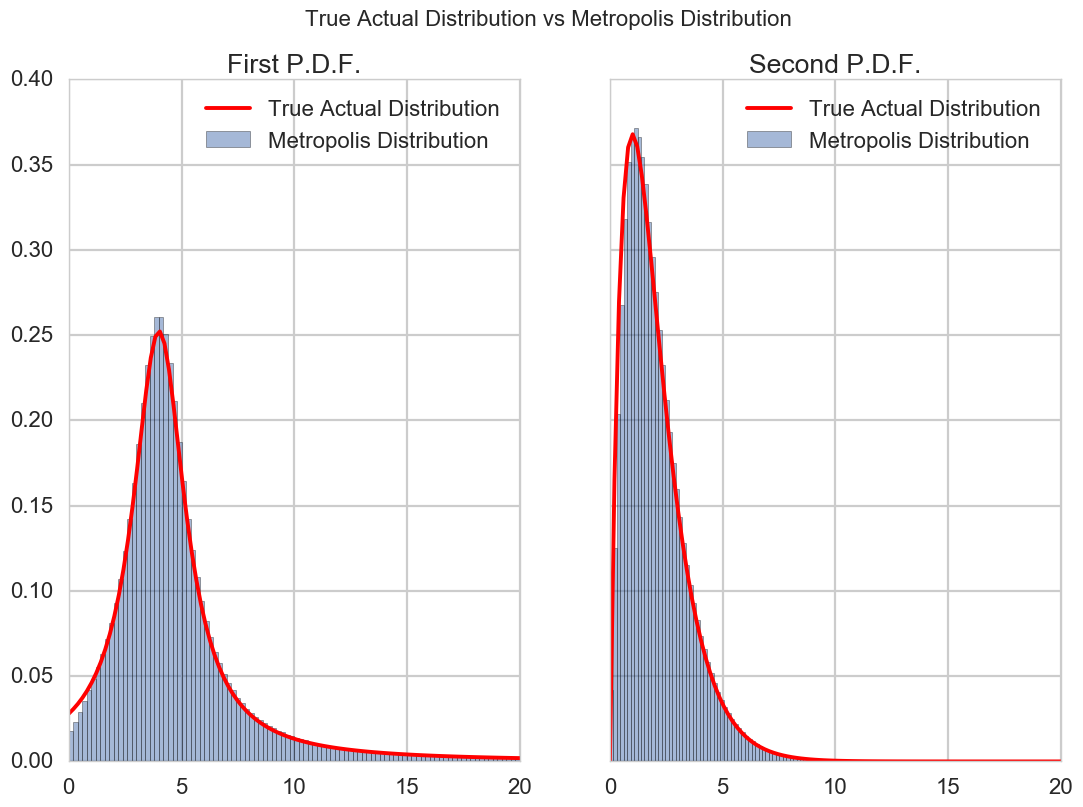

In [4]:
# rearrange samples and flatten them in preparation for visualization
first_pdf_samps_np = np.vstack(first_pdf_samps)
second_pdf_samps_np = np.vstack(second_pdf_samps)
f_flat = first_pdf_samps_np.flatten()
second_flat = second_pdf_samps_np.flatten()

# set the linspace to use for pdf output
xxxx = np.linspace(0, 20, 100)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.suptitle("True Actual Distribution vs Metropolis Distribution", fontsize=16)

ax1.set_title('First P.D.F.')
ax1.hist(f_flat[f_flat < 20], 
         bins=100, normed=True, alpha=0.5, label='Metropolis Distribution')
ax1.plot(xxxx, first_pdf_target(xxxx), color='red', label='True Actual Distribution')
ax1.legend()

ax2.set_title('Second P.D.F.')
ax2.hist(second_flat[second_flat < 20], 
         bins=100, normed=True, alpha=0.5, label='Metropolis Distribution')
ax2.plot(xxxx, second_pdf_target(xxxx), color='red', label='True Actual Distribution')
ax2.legend()

# Display and Compare the Variances of the two estimates

In [5]:
integrals_first_pdf = np.mean(first_pdf_h(first_pdf_samps_np), axis=1)
integrals_second_pdf = np.mean(second_pdf_h(second_pdf_samps_np), axis=1)

results = pd.DataFrame({'first_pdf': integrals_first_pdf, 
              'second_pdf': integrals_second_pdf})\
            .describe().ix[['mean','50%', 'std'], :]
results.ix['var', :] = np.square(results.ix['std', :])
results.ix['median', :] = results.ix['50%', :]

print ("The Variances are:")
results.ix['var'].head(10)

The Variances are:


first_pdf     0.035467
second_pdf    0.041884
Name: var, dtype: float64

# By normalizing the first p.d.f., we were able to reduce the overall bias and accomplish a better estimate!

In [6]:
# calculating the bias
def return_integrand(x):
    num = np.power(x, 4)*np.sin(np.log(x+1))*np.exp(-x)
    den = 2 + np.square((x - 4))
    return num / den

scipy_integral = spi.quad(return_integrand, 0, 10000)[0]
np.abs(results.ix['mean'] - scipy_integral)

first_pdf     0.053391
second_pdf    0.221346
Name: mean, dtype: float64

## Problem 2: Metropolis Algorithm

Suppose we ask you to memorize the order of the top five movies on IMDB. When we quiz you on the order afterwards, you might not recall the correct order, but the mistakes you will tend to make in your recall can be modeled by simple probabilistic models.
  
Let's say that the top five movies are:  
1. *The Shawshank Redemption*
2. *The Godfather*
3. *The Godfather: Part II*
4. *The Dark Knight*
5. *Pulp Fiction*

Let's represent this ordering by the vector $\omega = (1,2,3,4,5)$. 

If you were to mistakenly recall the top five movies as:
2. *The Godfather*
3. *The Godfather: Part II*
5. *Pulp Fiction*
4. *The Dark Knight*
1. *The Shawshank Redemption*

We'd represent your answer by the vector $\theta = (2,3,5,4,1)$.

Now, we have a way of quantifying how wrong your answer can be. We define the Hamming distance between two top five rankings, $\theta, \omega$, as follows:
$$d(\theta, \omega) = \sum_{i=1}^5 \mathbb{I}_{\theta_i\neq \omega_i},$$ 
where $\mathbb{I}_{\theta_i\neq \omega_i}$ is the indicator function that returns 1 if $\theta_i\neq \omega_i$, and 0 otherwise.

For example, the Hamming distance between your answer and the correct answer is $d(\theta, \omega)=4$, because you only ranked *The Dark Knight* is correctly. 

Finally, let's suppose that the probability of giving a particular answer (expressed as $\theta$) is modeled as
$$ p(\theta \,|\, \omega, \lambda) \propto  e^{-\lambda\, d(\theta,\, \omega)}.$$

### Part A:

Implement an Metropolis algorithm to produce sample guesses from 500 individuals, with various $\lambda$ values, $\lambda=0.2, 0.5, 1.0$. What are the top five possible guesses?

# Set up the functions needed for distance calculation

In [7]:
def calculate_hamming_distance(theta, omega):
    """
    Calculates the Hamming distance between
    vectors `theta` and `omega`.
    
    Note:
    =====
    `theta` and `omega` must be
    numpy arrays / pd.Series objects,
    or otherwise support elementwise
    vector operations.
    """
    return np.sum(theta != omega)

def p_theta(lamb, theta, omega):
    """
    Density for the probability `theta`.
    """
    return np.exp(-lamb*calculate_hamming_distance(theta, omega))

unif = np.random.random
lambdas = np.array([0.2, 0.5, 1.0])
omega_true = np.arange(1, 6)

def propose_ordering(*args, **kwargs):
    shuffle_this = np.arange(1, 6)
    np.random.shuffle(shuffle_this)
    return shuffle_this

# Define the metropolis algorithm

In [8]:
 # inspired by the lab implementation found at - https://am207.github.io/2017/wiki/bioassay.html
def metropolis_prob2(p, q_draw, stepsize, n_samp, x_init):

    # Initialize acceptance counts
    samples = []
    x_prev = x_init
    n_accepted = 0
    
    for i in range(n_samp):
        # get a sample from the proposal
        x_star = q_draw(x_prev, stepsize)
        
        # calculate ratio of the pdf
        pdf_ratio = p(x_star)/p(x_prev)
        if np.random.uniform() < min(1, pdf_ratio):
            samples.append(x_star)
            x_prev = x_star
            n_accepted += 1
        
        # if fail, keep previous
        else:
            samples.append(x_prev)
            
    # return our samples and the number of accepted steps        
    return samples, n_accepted

In [9]:
def compute_rankings(lam, nsamp=500):
    x0 = np.arange(1, 6)
    np.random.shuffle(x0)
    theta_samp, n_acc_theta = \
    metropolis_prob2(p=lambda theta: p_theta(lamb=lam, theta=theta, omega=np.arange(1,6)),
                                               q_draw=propose_ordering, stepsize=0.6, 
                                               n_samp=nsamp, x_init=x0)
    return theta_samp, n_acc_theta

# Run the simulation and display the top five possible guesses

In [10]:
sim = [compute_rankings(lam) for lam in lambdas]
sim_ranks = [np.vstack(t[0]) for t in sim]

for l, rank in zip(lambdas, sim_ranks):
    print('With Lambda Value of', l,'...')
    print('The Top 5 guesses were')
    print("\n".join(pd.Series([str(row) for row in rank]).value_counts().index.tolist()[:5]))
    print()

With Lambda Value of 0.2 ...
The Top 5 guesses were
[5 2 3 4 1]
[2 5 3 4 1]
[1 2 4 3 5]
[2 1 3 4 5]
[1 2 3 5 4]

With Lambda Value of 0.5 ...
The Top 5 guesses were
[1 2 3 4 5]
[4 2 3 1 5]
[2 1 3 4 5]
[1 4 3 5 2]
[1 3 2 4 5]

With Lambda Value of 1.0 ...
The Top 5 guesses were
[1 2 3 4 5]
[1 2 3 5 4]
[1 2 4 3 5]
[4 2 3 1 5]
[1 4 3 2 5]



### Part B:
Compute the probability that *The Shawshank Redemption* is ranked as the top movie (ranked number 1) by the Metropolis algorithm sampler. Compare the resulting probabilities for the various different $\lambda$ values. Summarize your findings.

10k sample guesses for each lambda value to calculate the prob. The Shawshank Redemption is ranked as the top movie

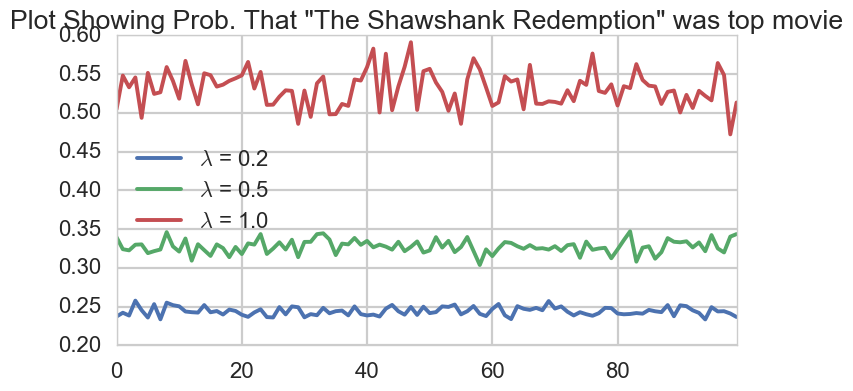

In [11]:
shawshankProb = [[np.mean(rank[:, 0] == 1) for rank in \
                            [np.vstack(rankings) for rankings, n_accs in \
                             [compute_rankings(lam, nsamp=10000) \
                               for lam in lambdas]]] for iteration in range(100)]

probResults = pd.DataFrame(np.vstack(shawshankProb), 
             columns=['$\lambda$ = {}'.format(l) for l in lambdas])

probResults.plot(figsize=(8, 4), title='Plot Showing Prob. That "The Shawshank Redemption" was top movie')
p_avgs = probResults.mean(axis=0)
plt.legend(loc='best')

# While the probabilities were closer to each other for lambda values .2 and .5, the highest probability that "The Shawshank Redemption" is ranked number 1 was with 1.0.